In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import seaborn as sns
from numpy import linalg as LA
from math import isnan
import time
import random
from PGF import* 

'''##########################################################################################################################################################'''
'''############################################################  DATA PROCESSING ############################################################################'''
'''##########################################################################################################################################################'''

''' 
1- return_clen_data_perfect: Functions that cleans data for the case of having infection times and infection  periods. Returns the individual
information for each node, when they got infected and recovered.  

2- func_wieiti: Takes the output of 1 and returns just a list of infection times, recovery times and infection periods
'''

def return_clen_data_perfect(data):
    N0=data[0,1]
    I0=data[0,2]
    rho = data[0,2]/N0
    nodes=[]
    data_S=[data[0]];data_R=[data[0]]
    data_dic={}
    for i in range(1, len(data)):
        if data[i-1, 1] - data[i, 1] == 1:
            data_S.append(data[i,])
        if data[i-1, 2] - data[i, 2] == 1:
            data_R.append(data[i,])
            
        if data[i, -1] not in nodes:
            nodes.append(data[i, -1])
            
    Infec_dic={}
    Rec_dic={}
    for S in data_S:
        Infec_dic[S[-1]]=S[0]

    for R in data_R:
        Rec_dic[R[-1]]=R[0]

    data_dic
    for node in nodes:
        if node in Infec_dic.keys() and node in Rec_dic.keys():
            data_dic[node]=[Infec_dic[node],Rec_dic[node],Rec_dic[node]-Infec_dic[node]]
        if node in Rec_dic.keys() and node not in Infec_dic.keys():
            data_dic[node]=[0,Rec_dic[node],Rec_dic[node]]
        if node in Infec_dic.keys() and node not in Rec_dic.keys():
            data_dic[node]=[Infec_dic[node],'NR','NR']  
    times=[]
    for node in nodes:
        if node !=-1:
            times.append(data_dic[node])

    times=sorted(times, key=lambda x: x[0])
    K0 = len(times) - I0  # final size of populatio
    return {'data': times, 'N0': N0, 'K0': K0, 'rho': rho, 'I0': I0}


def func_wieiti(data,Tmax=16):
    tr=[]; wi=[]; ei=[]; ti=[]
    list_=range(len(data))
    for i in list_:
        d=data[i]
        if d[0]!=0:
            ti.append(d[0])
        if d[1] != 'NR':
            tr.append(d[1])

    Tmax=max(max(ti),max(tr))
    for i in list_:
        d=data[i]
        if d[1]!='NR' and d[1]<Tmax:
            wi.append(d[1]-d[0])
        elif d[1]!='NR' and d[1]>Tmax:
            ei.append(Tmax-d[0])
            
    return ti,tr,wi,ei

'''##########################################################################################################################################################'''
'''############################################################  RAM ########################################################################################'''
'''##########################################################################################################################################################'''
''' Functions for S update'''

def cholupdate(L,x):
    n = len(x)
    for k in range(n):
        r = np.sqrt(L[k, k]**2 + x[k]**2)
        c = r / L[k, k]
        s = x[k] / L[k, k]
        L[k, k] = r
        if k < n-1:
            L[k+1:, k] = (L[k+1:, k] + s * x[k+1:]) / c
            x[k+1:] = c * x[k+1:] - s * L[k+1:, k]
    return L

def choldowndate(L,x):
    n = len(x)
    for k in range(n):
        r = np.sqrt(L[k, k]**2 - x[k]**2)
        c = r / L[k, k]
        s = x[k] / L[k, k]
        L[k, k] = r
        if k < n-1:
            L[k+1:, k] = (L[k+1:, k] - s * x[k+1:]) / c
            x[k+1:] = c * x[k+1:] - s * L[k+1:, k]
    return L

def adapt_S(S,u,alpha_n,i,gam,target_alpha=0.23):
    d=len(u)
    dif_alpha=alpha_n-target_alpha
    a=min(1,d*i**(-gam))*(abs(dif_alpha))
    u_norm=LA.norm(u)
    u_=(np.dot(S,u/u_norm))*np.sqrt(a)
    if dif_alpha>0:
        S=cholupdate(S,u_)
    else:
        S=choldowndate(S,u_)
    return S
    
def qlogis(x):
    if type(x)==list:
        result = []
        for ele in x:
            result.append(np.log(ele/(1-ele)))
        result=np.array(result)
    else:
        result=0
        result=np.log(x/(1-x))
    
    return result

def plogis(x):
    if type(x)==list:
        result=[]
        for ele in x:
            result.append(np.exp(ele)/(1+np.exp(ele)))
        result=np.array(result)
    else:
        result=0
        result= np.exp(x)/(1+np.exp(x))
    return result


'''##########################################################################################################################################################'''
'''######################################################  EBCM AND GENERATING FUNCTIONS ####################################################################'''
'''##########################################################################################################################################################'''
'''
The priors chosen for this case are gamma distribution non informative for beta, gamma, r and shift
and Beta distributions, non informative (uniform) for p and rho (which are restricted in the [0,1] range.

'''

def prior_value_func(x, prior_param):
    '''Our priors are gaussian distributions'''
    Prior=0
    #Priors for beta,gamma, and mu 
    for i in range (len(x)-1):
        a=prior_param[i][0]
        b=prior_param[i][1]
        Prior+=st.gamma(a=a, scale=b).logpdf(x[i])
    #Priors for  rho
    Prior+=st.beta(a=1, b=1).logpdf(x[-1])
    return Prior

def interp1d(obst, xmat):
    k = len(obst)
    jj = 0
    S_ti = np.zeros((k, xmat.shape[1]))
    S_ti[:, 0] = obst
    for i in range(k):
        for j in range(jj, xmat.shape[0]):
            if S_ti[i, 0] <= xmat[j, 0]:
                S_ti[i, 1:] = xmat[j, 1:]
                jj = j
                break
    return S_ti

''' EBMC '''
def ode_EBCM(para,dS,psi,d1_psi,Tmax,steps_ode):
    dt=Tmax/steps_ode
    b = para[0]; g = para[1]; ic = 1-1e-6; rho = para[-1]
    n = steps_ode + 1
    #####print(n)
    thetas=np.zeros(n); S=np.zeros(n); I=np.zeros(n); R=np.zeros(n)
    
    thetas[0]=ic
    S[0]=1
    I[0]=rho/(1-rho)
    R[0]=0
    for i in range(1, n):
        x = thetas[i-1]
        y = I[i-1]
        
        dth = -b * x + b *(1-rho)*d1_psi(x, para) / d1_psi(1, para) + g *(1-x)
        dr=g*y 
        thetas[i] = x + dth*dt
        R[i] = R[i-1] + dr*dt
        S[i] = psi(x,para)
        I[i]=1/(1-rho)-R[i]-S[i]
    return thetas,S,I,R

def dS_EBCM(theta, para, psi,d1_psi):
    b=para[0]; g=para[1]; rho = para[-1]
    res = d1_psi(theta, para)*(-b * theta + b* (1-rho)*d1_psi(theta, para) / d1_psi(1,para) + g *(1-theta))
    if np.max(res)>0:
        res = res - np.max(res) - 1e-100
    return res


'''##########################################################################################################################################################'''
'''######################################################  LIKELIHOODS AND AUXILIARY FUNC ###################################################################'''
'''##########################################################################################################################################################'''

def f_r(para,t,log=False):
    from scipy.stats import expon
    ''' Computes the fucntion f_R used in the likelihood function
    This fucntion is the porbability distirbution for the infection times'''
    gam=para[1]
    if log:
        return np.log((gam)*np.exp(-t*gam))
    else:
        return np.exp(-t/gam)

def I_tiu(I,times,para,tau):
    fr=[]
    g=para[1]; rho=para[-1]
    dt=times[-1]/len(times)
    
    for i in range (len(times)):
        fr.append(g*(I[i]-rho*np.exp(-g*times[i]))/tau)
    fr_Norm=sum(fr)*dt-0.5*(fr[0]+fr[-1])
    fr=np.array(fr)/fr_Norm
    return fr

def Log_Likelihood_L1(data_clear,wieiti,para,functions,T,steps_ode):
    '''Computes the Likelihood function
    Using the time of infection and infection period 
    '''
    psi,d1_psi,dS,prior_value=functions
    beta=para[0]; gam=para[1]; rho=para[-1]
    data_all=data_clear['data']
    wi,ei,ti = wieiti
    
    N=data_clear['N0']; K=data_clear['K0']; M=data_clear['I0']

    thetas,S,I,R = ode_EBCM(para,dS,psi,d1_psi,Tmax=T,steps_ode=steps_ode)
    tau = 1 - min(S)
    times=np.linspace(0,T,steps_ode+1)
    ft_res = np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    ft = interp1d(ti, ft_res)

    L1=(N-K)*np.log(1-tau)
    L2=K*np.log(tau)
    L3=np.nansum(np.log(ft[:,1]))

    Log_4=[]
    for t in wi:
        Log_4.append(f_r(para,t,log=True))
    L4=np.nansum(Log_4)
    L5=-gam*sum(ei)
    return L1+L2+L3+L4+L5

def Log_Likelihood_L2(data_clear,t_it_r,para,functions,T,steps_ode):
    '''Computes the Likelihood function 
    Using the time of recveory and time of infection
    '''
    proportion=0.1
    data_all=data_clear['data']
    psi,d1_psi,dS,prior_value=functions
    beta=para[0]; gam=para[1]; rho=para[-1]
    N=data_clear['N0']; K=data_clear['K0']; M=data_clear['I0']
    t_i,t_r=t_it_r

    thetas,S,I,R = ode_EBCM(para,dS,psi,d1_psi,Tmax=T,steps_ode=steps_ode)
    tau = 1 - min(S)
    times=np.linspace(0,T,steps_ode+1)

    ft_ode=np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    fr_ode=np.column_stack((times,I_tiu(I,times,para,tau)))

    ft = interp1d(t_i, ft_ode)
    fr= interp1d(t_r, fr_ode)

    L1=(N-K)*np.log(1-tau)
    L2=K*np.log(tau)

    L3=np.nansum(np.log(ft[:,1]))
    L4=np.nansum(np.log(fr[:,1]))
    return L1+L2+L3+L4


def Log_Likelihood_L3(data_clear,t_it_r,para,functions,T,steps_ode):
    '''Computes the Likelihood function 
    Using just the time of infection
    '''
    proportion=0.1
    data_all=data_clear['data']
    psi,d1_psi,dS,prior_value=functions
    beta=para[0]; gam=para[1]; rho=para[-1]
    N=data_clear['N0']; K=data_clear['K0']; M=data_clear['I0']
    t_i,t_r=t_it_r

    thetas,S,I,R = ode_EBCM(para,dS,psi,d1_psi,Tmax=T,steps_ode=steps_ode)
    tau = 1 - min(S)
    times=np.linspace(0,T,steps_ode+1)

    ft_ode=np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    ft = interp1d(t_i, ft_ode)

    L1=(N-K)*np.log(1-tau)
    L2=K*np.log(tau)

    L3=0
    for f in ft:
        L3+=np.log(f[1])
    return L1+L2+L3


def Log_Likelihood_L4(data_clear,t_it_r,para,functions,T,steps_ode):
    '''Computes the Likelihood function 
    Using just the time of recveory 
    '''
    proportion=0.1
    data_all=data_clear['data']
    psi,d1_psi,dS,prior_value=functions
    beta=para[0]; gam=para[1]; rho=para[-1]
    N=data_clear['N0']; K=data_clear['K0']; M=data_clear['I0']
    t_i,t_r=t_it_r
    
    thetas,S,I,R = ode_EBCM(para,dS,psi,d1_psi,Tmax=T,steps_ode=steps_ode)
    tau = 1 - min(S)
    times=np.linspace(0,T,steps_ode+1)

    ft_ode=np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    fr_ode=np.column_stack((times,I_tiu(I,times,para,tau)))
    
    fr= interp1d(t_r, fr_ode)

    L1=(N-K)*np.log(1-tau)
    L2=K*np.log(tau)
        
    L4=0
    for f in fr:
        L4+=np.log(f[1])

    return L1+L2+L4

def accept_proposal(proposal, current, prior_param, data, celar_times,Log_Likelihood, functions, T, A, steps_ode):
    ''' Function used to accept of reject the proposal'''
    prior_value=functions[-1]
    #Current values
    if A is None:
        prior_current = prior_value(current, prior_param)
        Jac_curr=sum(np.log(current)) + np.log(1-current[-1])
        likelihood_current = Log_Likelihood(data, celar_times,current,functions,T,steps_ode)
        A=likelihood_current + Jac_curr+prior_current 

    #Proposal
    prior_proposal = prior_value(proposal, prior_param)
    Jac_prop=sum(np.log(proposal)) + np.log(1-proposal[-1])
    likelihood_proposal = Log_Likelihood(data,celar_times,proposal,functions,T,steps_ode)
    #Aceptance
    B= likelihood_proposal + Jac_prop +prior_proposal 
    return np.exp(B-A),A,B


'''##########################################################################################################################################################'''
'''#################################################################  MAIN FUNCTION #########################################################################'''
'''##########################################################################################################################################################'''

def RAM_EBCM(data, initial_para, prior_param,functions, T,known_para, sample_size=2000,progress=True,steps_ode=4000, Data_type='NB',var_01=2):
    '''
    Perfect data: Infection time and infection period (L1+L2)
    Event data: Infection time and Recovery time (L1+L3)
    Infection data: Infection times (L1)
    Recovery data: Recovery times (L3)
    '''
    proportion=0.1
    data_clear=return_clen_data_perfect(data)
    data_node=data_clear['data']
    data=random.sample(data_node, k=int(proportion*len(data_node)))

    t_i,t_r,w_i,e_i=func_wieiti(data)
    T=max(max(t_i),max(t_r))
    
    if Data_type=='L1+L2':
        Log_Likelihood=Log_Likelihood_L1
        w_i=sorted(w_i);e_i=sorted(e_i);t_i=sorted(t_i)
        celar_times=w_i,e_i,t_i
        print('Likelihood 1 - Infection times and Infection period')
        
    elif Data_type=='L1+L3':
        t_r=sorted(t_r); t_i=sorted(t_i)
        celar_times=t_i,t_r
        Log_Likelihood=Log_Likelihood_L2
        print('Likelihood 2 - Infection and Recovery times')

    elif Data_type=='L1':
        t_r=sorted(t_r); t_i=sorted(t_i)
        celar_times=t_i,t_r
        Log_Likelihood=Log_Likelihood_L3
        print('Likelihood 3 - Infection times')

    elif Data_type=='L3':
        t_r=sorted(t_r); t_i=sorted(t_i)
        celar_times=t_i,t_r
        Log_Likelihood=Log_Likelihood_L4
        print('Likelihood 3 - Recovery times')
    
    current = initial_para
    trace = [current]
    dim=len(initial_para)
    theta0=1e-6
    
    A=None
    psi,d1_psi=functions[0], functions[1]
    #The Matrix S begind as and identity matrix
    S0 = np.identity(dim)
    S = S0

    acceptence_history=[]
    acceptances=0; iterations=0; porcentage=0
    while iterations<sample_size:
        #Used to show the progress in each inferenc process
        if iterations == porcentage*sample_size/10 and progress==True:
            print(10*porcentage, '%')
            porcentage += 1
    
        iterations += 1
        prop_test=1

        #Proporsal Y=X+u*S
        c=0
        while prop_test>0:
            #u_prop = np.random.multivariate_normal([0] * dim, np.diag([0.01] * dim), size=1)[0]
            u_prop = np.random.multivariate_normal(mean=np.zeros(dim), cov=np.diag(np.ones(dim) * 0.01))
            S_proposal = np.concatenate((np.log(current[0:dim-1]),qlogis(current[-1:]))) + S@u_prop
            proposal = np.concatenate((np.exp(S_proposal[0:dim-1]),plogis(S_proposal[-1:])))
            prop_test=-proposal[0] * (1-theta0) + proposal[0] * (1-proposal[-1]) *d1_psi(1-theta0,proposal)/(d1_psi(1,proposal)) + proposal[1] *(theta0)
            if prop_test<0:
                break
        if known_para is not None:
            for i in range(len(known_para)):
                known=known_para[i]
                proposal[known[0]]=known[1]

        
        if np.min(proposal) < 1e-200:
            proposal += 1e-200

        alpha_n,A,B=accept_proposal(proposal, current, prior_param, data_clear, celar_times, Log_Likelihood, functions, T, A, steps_ode)
        alpha_n= min(1,alpha_n)
        u_rand = np.random.rand()
    
        if u_rand < alpha_n and isnan(alpha_n) == False:
            acceptances += 1
            current = proposal
            A=B
        
        trace.append(current)
        acc_ratio=acceptances/iterations
        S=adapt_S(S,u_prop,alpha_n,i=iterations,gam=min(1,-2/3))
        acceptence_history.append(acc_ratio)
        
    return trace, acceptence_history

def Inference_RAM(loc, initial_para, prior_param, T, sample_size=2000,progress=True,steps_ode=4000, Degree_distrib='NB', data_sets=1, Data_type='Perfect', known_para=None):
    
    dS=dS_EBCM
    prior_value=prior_value_func
    
    if Degree_distrib=='Poi':
        if len(initial_para)!=4:
            print('Problem with initial parameter size')
        psi=psi_Poi
        d1_psi=d1_psi_Poi
        var_01=1
        
    elif Degree_distrib=='Reg':
        if len(initial_para)!=4:
            print('Problem with initial parameter size')
        psi=psi_Reg
        d1_psi=d1_psi_Reg
        var_01=1

    elif  Degree_distrib=='NB':
        if len(initial_para)!=5:
            print('Problem with initial parameter size')
        psi=psi_NB
        d1_psi=d1_psi_NB
        var_01=1
        
    
    functions=(psi,d1_psi,dS,prior_value)
    Postiriors_file=[]
    
    for i in range (data_sets):
        print('Data set ' + Degree_distrib + ' ' + str(i))
        df=pd.read_csv(loc + str(i) + '.csv',header=None)
        data=np.array(df)
        
        trace,acceptence_history = RAM_EBCM(data,initial_para,prior_param,functions,T,known_para,sample_size=sample_size,steps_ode=steps_ode,progress=progress, 
                                            Data_type=Data_type,var_01=var_01)
        Traces=[]
        for i in range (len(trace[0])):
            Traces.append([x[i] for x in trace])
            
        Distribs=Burn_in(Traces,burn_in=0)
        Postiriors_file.append(Distribs)
    return Postiriors_file

In [86]:
start =  time.time()

from math import isnan
beta = 0.2; gamma = 1; mu = 10; r = 1; shift=3; rho = 1/10000
T = 25
para_real = [beta,gamma,mu,r,rho]

theta0=1e-6
dim = len(para_real)
#Prior Parameters
prior_param = []
for p in para_real:
    prior_param.append([p/10,10])
    
prior_param[-1][0] = 1; prior_param[-1][1] = 1
chain_lenght=2000
resol=200
num_sets=1
''' #################################################### SIMULATION ###############################################################'''

loc='../../../Data_sets/Data_from_Poisson_per_node/Data_from_Poisson_per_node/epidata_Poisson_'
Postirior=Inference_RAM(loc, para_real, prior_param, T, sample_size=chain_lenght,progress=False,steps_ode=resol, Degree_distrib='NB',data_sets=num_sets, Data_type='L1+L2')
Postiriors_file_array=np.array(Postirior)
Postiriors_file_reshaped = Postiriors_file_array.reshape(Postiriors_file_array.shape[0], -1)
np.savetxt("Poi_L1L2_f_250ds.csv", Postiriors_file_reshaped, delimiter=",")

end =  time.time()
print('Time', end - start)

Data set NB 0
Likelihood 1 - Infection times and Infection period


C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_23368\3501720928.py:287: RuntimeWarning: divide by zero encountered in divide
  ft_res = np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_23368\3501720928.py:291: RuntimeWarning: divide by zero encountered in log
  L2=K*np.log(tau)
C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_23368\3501720928.py:300: RuntimeWarning: invalid value encountered in scalar add
  return L1+L2+L3+L4+L5
C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_23368\3501720928.py:403: RuntimeWarning: overflow encountered in exp
  return np.exp(B-A),A,B


Time 20.23447012901306


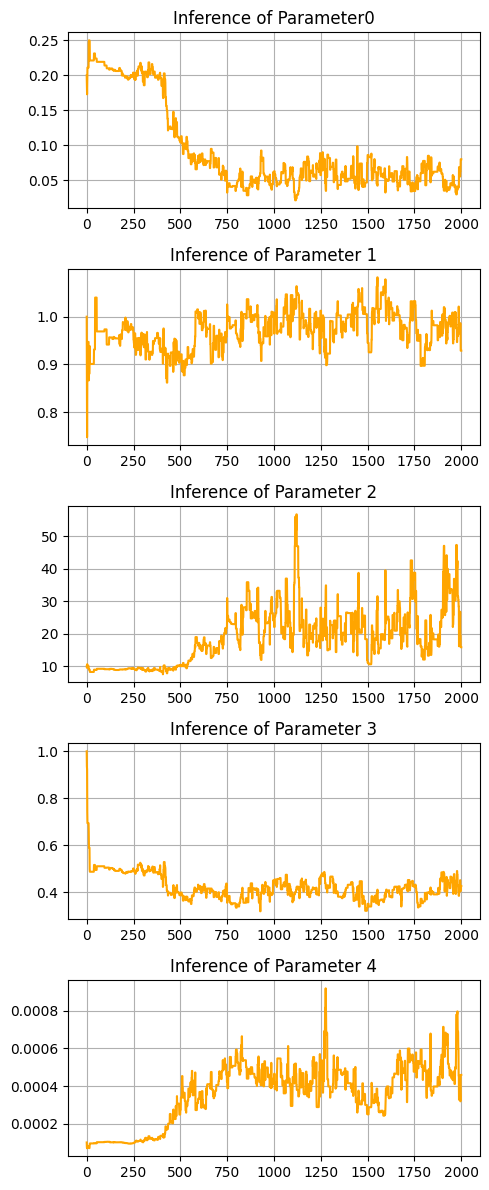

In [85]:
from Trace_analysis_final import *
Plot_chains(Postirior[0])

In [73]:
print(np.mean(Postirior[0][3][-1000:]))

38.657860701010364
